# Détection d’objets en mouvement avec un Spiking Neural Network sur des données de caméra neuromorphique

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.clock_driven import neuron, functional
import matplotlib.pyplot as plt
import os

In [ ]:
data_dir = r'./Datasets'
print("Contenu du dossier :", os.listdir(data_dir))
print("Sous-dossiers :", os.listdir(os.path.join(data_dir, "download")))

print("Sous-dossiers :", os.listdir(os.path.join(data_dir, "download/DvsGesture")))


Contenu du dossier : ['download']
Sous-dossiers : ['DvsGesture']
Sous-dossiers : ['download', 'events_np', 'extract', 'frames_number_10_split_by_number']


In [ ]:

print("GPU disponible :", torch.cuda.is_available())
print("Appareil utilisé :", "GPU" if torch.cuda.is_available() else "CPU")


GPU disponible : True
Appareil utilisé : GPU


In [ ]:
data_dir = './Datasets/download/DvsGesture/'

train_set = DVS128Gesture(
    root=data_dir,
    train=True,
    data_type='frame',   
    frames_number=10,    
    split_by='number'    
)

test_set = DVS128Gesture(
    root=data_dir,
    train=False,
    data_type='frame',
    frames_number=10,
    split_by='number'
)

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, num_workers=2)

print(f"Nombre d’échantillons d’entraînement : {len(train_set)}")
print(f" Nombre d’échantillons de test : {len(test_set)}")

for imgs, labels in train_loader:
    print("Taille des images :", imgs.shape)  
    print("Labels :", labels)
    break



The directory [./Datasets/download/DvsGesture/frames_number_10_split_by_number] already exists.
The directory [./Datasets/download/DvsGesture/frames_number_10_split_by_number] already exists.
Nombre d’échantillons d’entraînement : 1176
 Nombre d’échantillons de test : 288
Taille des images : torch.Size([8, 10, 2, 128, 128])
Labels : tensor([2, 3, 1, 7, 8, 0, 6, 4])


In [ ]:
class SimpleSNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 12, kernel_size=5, stride=1, padding=2)
        self.lif1 = neuron.LIFNode()
        self.pool1 = nn.AvgPool2d(2)

        self.conv2 = nn.Conv2d(12, 32, kernel_size=5, stride=1, padding=2)
        self.lif2 = neuron.LIFNode()
        self.pool2 = nn.AvgPool2d(2)

        # Calcul de la taille d'entrée
        with torch.no_grad():
            dummy = torch.zeros(1, 2, 128, 128)  
            out = self.pool1(self.lif1(self.conv1(dummy)))
            out = self.pool2(self.lif2(self.conv2(out)))
            flatten_dim = out.numel()
        print(f"Taille d’entrée du FC : {flatten_dim}")
        self.fc = nn.Linear(flatten_dim, 11)  

    def forward(self, x):
        # x : [T, N, C, H, W]
        x = x.float()
        T = x.shape[0]
        out_spikes_counter = torch.zeros(x.shape[1], 11, device=x.device)
        functional.reset_net(self)

        for t in range(T):
            out = self.conv1(x[t])
            out = self.lif1(out)
            out = self.pool1(out)

            out = self.conv2(out)
            out = self.lif2(out)
            out = self.pool2(out)

            
            if t == 0:
                print("Shape avant flatten :", out.shape)

            out = out.flatten(1)
            out = self.fc(out)
            out_spikes_counter += out

        return out_spikes_counter / T


In [ ]:
# Entraînement
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SimpleSNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 3
loss_history = []

print("Début de l'entraînement...\n")
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for frame, label in train_loader:
        frame = frame.to(device)
        label = label.to(device)
        frame = frame.permute(1, 0, 2, 3, 4)  

        optimizer.zero_grad()
        out = model(frame)
        loss = criterion(out, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {avg_loss:.4f}")

print("\n Entraînement terminé !")


Taille d’entrée du FC : 32768
Début de l'entraînement...

Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 3

In [ ]:
# Évaluation 
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for frame, label in test_loader:
        frame = frame.to(device)
        label = label.to(device)
        frame = frame.permute(1, 0, 2, 3, 4)
        out = model(frame)
        preds = torch.argmax(out, dim=1)
        correct += (preds == label).sum().item()
        total += label.size(0)

acc = 100 * correct / total
print(f"\n Précision finale sur le jeu de test : {acc:.2f}%")

Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])
Shape avant flatten : torch.Size([8, 32, 32, 32])


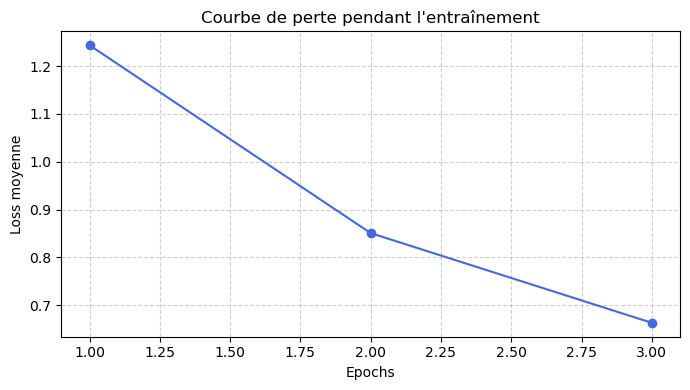

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(range(1, epochs + 1), loss_history, marker='o', color='royalblue')
plt.title("Courbe de perte pendant l'entraînement")
plt.xlabel("Epochs")
plt.ylabel("Loss moyenne")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()